In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import chi2_contingency
import math
from collections import Counter
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder
#pip install delayed
from imblearn.over_sampling import SMOTE
from collections import Counter

In [10]:
# Load the train and test datasets
df_train = pd.read_csv('../../../Data/paths_AOA_trainData.csv')
df_test = pd.read_csv('../../../Data/paths_AOA_testData.csv')

## 1. Select all variables

In [11]:
# Initial variables for the model. 
# I focus exclusively on the pre services and loc plus demographics with less than 20% of missing data.

id_cols = ['id', 'client_id']

demo_cols = ['age', 'age_group','race','gender','dx_group','lang', 'substance','insurance','emp', 'educ','liv','justice', 'sexorient', 'co']

ip_cols = ['as_loc', 'as_length_IP', 'IP_history', 'as_close']

loc_pre_cols = ['loc1_pre', 'loc2_pre', 'loc3_pre', 'loc4_pre', 'loc5_pre']

svc_total_pre_cols = ['new', 'svc_pre_all', 'svc_pre', 'svc_pre_sub']

svc_AOA_timepoint_pre_cols = ['svc_AOA_op_7days_pre', 'svc_AOA_op_30days_pre', 'svc_AOA_op_60days_pre', 'svc_AOA_op_90days_pre',
                     'svc_AOA_es_7days_pre', 'svc_AOA_es_30days_pre', 'svc_AOA_es_60days_pre', 'svc_AOA_es_90days_pre',
                     'svc_AOA_24h_7days_pre', 'svc_AOA_24h_30days_pre', 'svc_AOA_24h_60days_pre', 'svc_AOA_24h_90days_pre',
                     'svc_AOA_ip_7days_pre', 'svc_AOA_ip_30days_pre', 'svc_AOA_ip_60days_pre', 'svc_AOA_ip_90days_pre']

output_col = ['svc_AOA_ip_90days_postdc_bi']

drop_cols = ['']

In [12]:
numerical_features = ['age','as_length_IP', 'IP_history', 'svc_pre_all', 'svc_pre', 'svc_pre_sub']
numerical_features = numerical_features  + svc_AOA_timepoint_pre_cols

In [13]:
dummy_vars = df_train.loc[:, 'age_group_Age 60+':'loc5_pre_WRAP']
dummy_vars = list(dummy_vars.columns)
categorical_features = dummy_vars + ['co', 'substance', 'justice','new']

In [14]:
all_features = numerical_features + categorical_features
len(all_features)

262

In [15]:
# Get the X and y from train (original), train (re-sampling) and test datasets
Xtrain = df_train[all_features]
ytrain = df_train['svc_AOA_ip_90days_postdc_bi']
Xtest = df_test[all_features]
ytest = df_test['svc_AOA_ip_90days_postdc_bi']
SEED = 200

In [16]:
# scaling is necessary for some algorithms
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

## 2. Feature Selection 

### a. Check the correlation among features and remove redundant ones

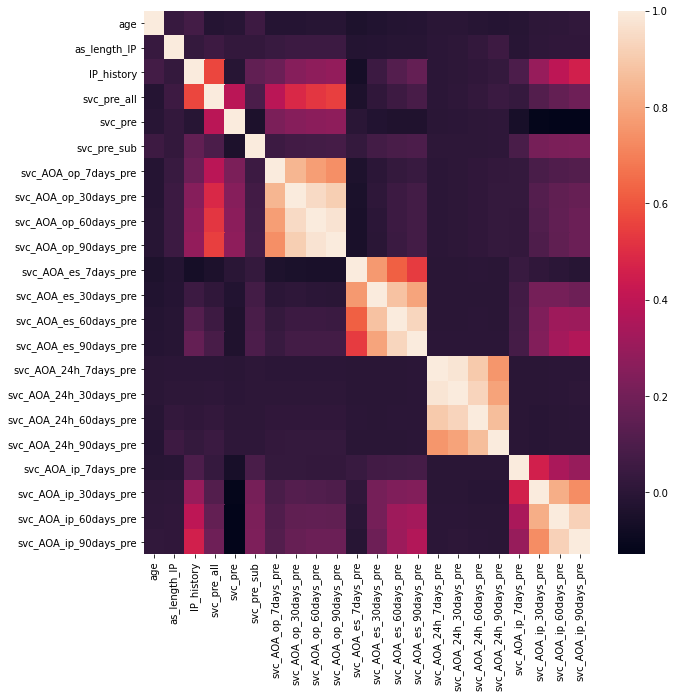

In [17]:
# Correlation heatmap
corr_num = Xtrain[numerical_features].corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr_num)

In [18]:
from itertools import compress

# Define a function for generating the array and dictionary with correlated columns
def corr_extractor(corr_mat, cols_list, thresh):
    """With correlation matrix, list of columns (for which the 
    correlation matrix was calculated), and threshold (for 
    cooefficient comparison) as input return an array of 
    redundant column (to drop) and a dictionary to inspect 
    the correlations."""
    corr_mat_asym = np.tril(corr_mat, -1) # set the top half triangle of the matrix (including main diagonal) to 0
    bool_mask = abs(corr_mat_asym)>=thresh # create a boolean mask for values above the threshold

    corr_array = [] # initiate empty array and dictionary
    corr_dict = {}
    
    for i in range(len(cols_list)): 
        # iterate through the columns in cols_array and extract the associated column names with the boolean mask
        cors = list(compress(cols_list, bool_mask[:,i]))
        if cors!= []:
            corr_dict[cols_list[i]]=[]
            # create a key value pair, key= (query) column name values = list of associated columns
            corr_dict[cols_list[i]]+=cors
            for elem in cors:
                corr_array.append(elem) # create a list only with the redundant column (excluding the query)
    
    corr_array = list(dict.fromkeys(corr_array)) # drop duplicates
    
    return corr_array, corr_dict

In [19]:
# Calculate Pearson correlation coefficient
num_corr_mat = np.corrcoef(Xtrain[numerical_features].values, rowvar=False)

# Remove redundant features that have a correlation higher than 0.9 
num_corr_to_drop, num_corr_dict = corr_extractor(num_corr_mat, numerical_features, 0.90)
print("The number of all numerical features is ", len(numerical_features))
print("The number of redundant numerical features is ", len(num_corr_to_drop))
print("The number of remaining numerical features is ", len(numerical_features)-len(num_corr_to_drop))

The number of all numerical features is  22
The number of redundant numerical features is  6
The number of remaining numerical features is  16


In [20]:
numerical_features2 = (list(set(numerical_features) - set(num_corr_to_drop)))
num_corr_to_drop

['svc_AOA_op_60days_pre',
 'svc_AOA_op_90days_pre',
 'svc_AOA_es_90days_pre',
 'svc_AOA_24h_30days_pre',
 'svc_AOA_24h_60days_pre',
 'svc_AOA_ip_90days_pre']

In [21]:
Xtrain_corSelect = Xtrain.drop(columns = num_corr_to_drop)

In [22]:
def cramers_v(x, y):
    """A function to compute Cramer's V, effect size measure for strength of association"""
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [23]:
# calculate Cramer's V coefficient for all categorical features
start_time = time.monotonic()
x = Xtrain[categorical_features]
corr_mat_cat = np.zeros((len(x.columns), len(x.columns)))
for i in range(len(x.columns)):
    for j in range(len(x.columns)):
        corr_mat_cat[i,j] = cramers_v(x.iloc[:,i], x.iloc[:,j])
time_elapsed = (time.monotonic()-start_time)/60
print("Calculation took %.3f minutes" % time_elapsed)

Calculation took 31.306 minutes


In [24]:
#determine the categorical features that have a Cramer's V coeffient above 0.9
cat_corr_to_drop, cat_corr_dict = corr_extractor(corr_mat_cat, categorical_features, 0.9)
print("The number of all categorical features is ", len(categorical_features))
print("The number of redundant categorical features is ", len(cat_corr_to_drop))
print("The number of remaining categorical features is ", len(categorical_features)-len(cat_corr_to_drop))

The number of all categorical features is  240
The number of redundant categorical features is  2
The number of remaining categorical features is  238


In [25]:
categorical_features2 = (list(set(categorical_features) - set(cat_corr_to_drop)))
cat_corr_to_drop

['new', 'substance']

In [26]:
Xtrain_corSelect = Xtrain_corSelect.drop(columns = cat_corr_to_drop)
Xtest_corSelect = Xtest.drop(columns = cat_corr_to_drop+num_corr_to_drop)

In [27]:
Xtrain_scaled2 = scaler.fit_transform(Xtrain_corSelect)
Xtest_scaled2 = scaler.fit_transform(Xtest_corSelect)

### b. Select variables by Boruta algorithm

In [28]:
#!pip install boruta

In [29]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [30]:
# initialize Boruta
forest = RandomForestRegressor(
   n_jobs = -1, 
   max_depth = 5
)
boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 100,
   max_iter = 100 # number of trials to perform
)

In [31]:
len(Xtrain_scaled2)

83936

In [32]:
len(ytrain)

83936

In [33]:
# define dataset
X, y = Xtrain_scaled2, ytrain
# fit Boruta 
start_time = time.monotonic()
boruta.fit(np.array(X), np.array(y))
print("Time elapsed {}s".format(time.monotonic()-start_time))


Time elapsed 1004.5s


In [34]:
all_features_array = np.array(Xtrain_corSelect.columns)

In [35]:
green_area = all_features_array[boruta.support_].tolist()
blue_area = all_features_array[boruta.support_weak_].tolist()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

features in the green area: ['as_length_IP', 'IP_history', 'svc_pre_all', 'svc_pre', 'svc_AOA_ip_60days_pre', 'dx_group_Depressive Disorders', 'dx_group_Schizophrenia and Other Psychotic Disorders', 'educ_Unknown/Not Reported', 'liv_Lives Independently', 'sexorient_Missing/Not Reported', 'as_loc_IPFFS', 'as_loc_IPLIHP', 'as_close_IMD/MHRC', 'as_close_Psychiatric Hospital', 'loc1_pre_None', 'co']
features in the blue area: []


In [36]:
# Selected features for the models
boruta_selected_features = green_area + blue_area
len(boruta_selected_features)

16

In [37]:
Xtrainb = Xtrain[boruta_selected_features]
Xtestb = Xtest[boruta_selected_features]

In [38]:
Xtrainb_scaled = scaler.fit_transform(Xtrainb)
Xtestb_scaled = scaler.transform(Xtestb)

## 3. Data Sampling

Class 0: 51575
Class 1: 32361
Proportion: 1.59 : 1


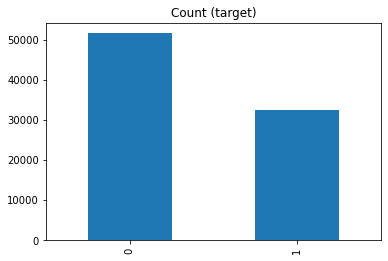

In [39]:
# Check the class for the outcome variable 
target_count=ytrain.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')

In [40]:
# Class Imbalance Processing: Using re-sampling method
print('Original dataset shape {}'.format(Counter(ytrain)))
sm = SMOTE(random_state=SEED)
Xtrain_scaled, ytrain_new = sm.fit_sample(Xtrain_scaled, ytrain)
print('New dataset shape {}'.format(Counter(ytrain_new)))

Original dataset shape Counter({0: 51575, 1: 32361})
New dataset shape Counter({1: 51575, 0: 51575})


In [41]:
# Class Imbalance Processing: Using re-sampling method
print('Original dataset shape {}'.format(Counter(ytrain)))
sm = SMOTE(random_state=SEED)
Xtrainb_scaled, ytrain_new = sm.fit_sample(Xtrainb_scaled, ytrain)
print('New dataset shape {}'.format(Counter(ytrain_new)))

Original dataset shape Counter({0: 51575, 1: 32361})
New dataset shape Counter({1: 51575, 0: 51575})


In [42]:
ytrain = ytrain_new

## Save the datasets

In [43]:
np.save(r'Xtrain_scaled', Xtrain_scaled)
np.save(r'Xtest_scaled', Xtest_scaled)
np.save(r'Xtrainb_scaled', Xtrainb_scaled)
np.save(r'Xtestb_scaled', Xtestb_scaled)
np.save(r'ytrain', ytrain)
np.save(r'ytest', ytest)


## Archives

In [ ]:
'''
SEED = 200
# import datetime
from datetime import datetime

# import a host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# import model metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# import ROC_AUC scoring, we will use area under the ROC curve for comparison
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True, class_weight='balanced')
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=1, random_state=SEED, solver='liblinear', class_weight='balanced')
    nn = MLPClassifier((100, 50), early_stopping=True, random_state=SEED, max_iter=400, activation='tanh')
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED, class_weight='balanced')

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models


def train_predict(model_list, xtrain, ytrain, xtest):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        current_time = datetime.now() 
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        time_elapsed = datetime.now() - current_time
        print("Time elapsed ", time_elapsed)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        ap = average_precision_score(y, P.loc[:, m])
        print("%-26s: %.3f, %.3f" % (m, score, ap))
    print("Done.\n")
'''

In [ ]:
'''
models = get_models()
P = train_predict(models, Xtrain_scaled, ytrain, Xtest_scaled)
score_models(P, ytest)
'''

### Archive codes

In [ ]:
'''
# Map values
dx_group_dict = {0:'Anxiety Disorders', 1:'Bipolar Disorders', 2:'Depressive Disorders', 3: 'Other/ Excluded',
                4: 'Schizophrenia and Other Psychotic Disorders', 5: 'Stressor and Adjustment Disorders'}
lang_dict = {0:'Asian languages', 1:'English', 2:'Middle Eastern languages', 3:'Other/Unknown', 4:'Spanish'}
insurance_dict = {0:'Medi-Cal + Medicare', 1:'Private', 2:'Uninsured/Unknown'}
emp_dict = {0:'Competitive Job', 1:'Not Seeking Work', 2:'Not in Labor Force', 3:'Other', 4:'Resident/Inmate of Institution',
           5:'Seeking Work', 6:'Unknown'}
educ_dict = {0:'Associates Degree', 1:'Bachelors Degree', 2:'High School Diploma/GED', 3:'High School Not Completed',
            4:'Masters Degree', 5:'Some College/Vocational Training', 6:'Unknown/Not Reported'}
liv_dict = {0:'Board & Care', 1:'Homeless', 2:'Institutional', 3:'Justice Related', 4:'Lives Independently', 5:'Other/Unknown'}
sexorient_dict = {0:'Bisexual', 1:'Decline to State', 2:'Deferred', 3:'Gay Male', 4:'Heterosexual', 5:'Lesbian',
                 6:'Missing', 7:'Other', 8:'Questioning', 9:'Transgender'}
df2['dx_group'] = df2['dx_group'].map(dx_group_dict)
df2['lang'] = df2['lang'].map(lang_dict)
df2['insurance'] = df2['insurance'].map(insurance_dict)
df2['emp'] = df2['emp'].map(emp_dict)
df2['educ'] = df2['educ'].map(educ_dict)
df2['liv'] = df2['liv'].map(liv_dict)
df2['sexorient'] = df2['sexorient'].map(sexorient_dict)
'''

In [ ]:
'''
#Impute missing value with mean
for col in numerical_features:
    df[col].fillna(df[col].mean(), inplace=True)
'''

In [ ]:
'''
# Create dummy variables for non-binary categorical variables
df = pd.get_dummies(df, columns=['age_group','race','gender','dx_group','lang', 'insurance','emp', 'educ','liv', 'sexorient',
                       'as_loc', 'as_close','loc1_pre', 'loc2_pre', 'loc3_pre', 'loc4_pre', 'loc5_pre'], drop_first=True)

'''

In [ ]:
'''
# impute missing values of categorical features with the most frequent object
for col in categorical_features:
    df[col].fillna(df[col].value_counts().index[0], inplace=True)
'''

In [ ]:
'''
logistic = LogisticRegression(C=1, penalty="l1", solver='liblinear', random_state = SEED).fit(Xtrain, ytrain)
model = SelectFromModel(logistic, prefit=True)
X_new = model.transform(Xtrain)
'''

In [ ]:
'''
pd.set_option('max_rows', None)
Xtrain.dtypes


# Plot the pair scatter plot to check the distribution of numerical features
sns.set()
sns.pairplot(Xtrain[numerical_features], size = 2.5)
plt.show();
'''

In [ ]:
'''
df=pandas.DataFrame(x_scaled, columns=df.columns)
'''